In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import tree
import xgboost as xgb

In [2]:
#df = pd.read_excel('/Users/jakubkudryk/Documents/PWR/Magisterka/Semestr_1/statystyka/lab2/POSE-205.xlsx')
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SAD/POSE-205.xlsx')

In [3]:
df.describe()
df.dtypes
df.shape

(570209, 22)

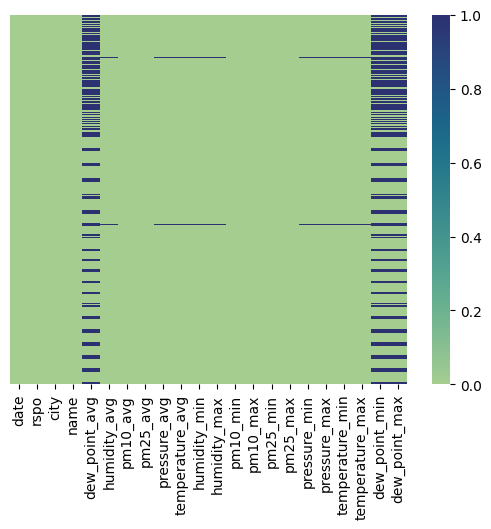

In [4]:
sns.heatmap(df.isna(), yticklabels=False, cmap='crest')
plt.show()

In [5]:
df = df.drop(columns=['dew_point_avg', 'dew_point_max', 'dew_point_min', 'city', 'name'])
df = df.dropna()

In [6]:
df2 = df.copy()
df2.drop(columns=['rspo'], inplace=True)

In [7]:
df_ready = df.copy()

# Preprocesing

In [8]:
y_pm25 = df_ready['pm25_avg']

In [9]:
df_ready = df_ready.drop(columns=['rspo', 'pm25_avg', 'pm25_min', 'pm25_max'])

In [10]:
df_ready['date'] = pd.to_datetime(df_ready['date'])
df_ready.set_index('date', inplace=True)

In [11]:
y = df_ready['pm10_avg']
df_actually_ready = df_ready.copy()
df_actually_ready = df_actually_ready.drop(columns=['pm10_max', 'pm10_min', 'pm10_avg'])

X = df_actually_ready

In [12]:
X_train, X_test, y_train, y_test_pm10 = train_test_split(X,y ,
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

In [13]:
X_train_pm25, X_test_pm25, y_train_pm25, y_test_pm25 = train_test_split(X,y_pm25 ,
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

# Trenowanie modeli

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:48:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


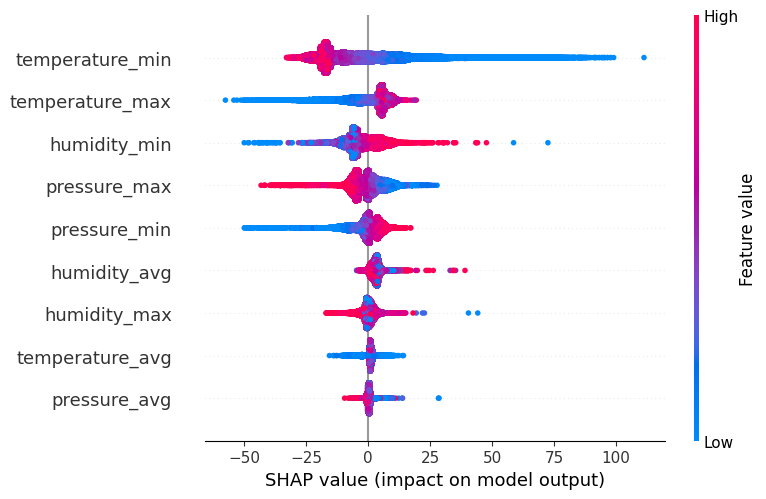

In [14]:
dtree_pm10 = xgb.XGBRegressor(min_samples_split=20)
dtree_pm10.fit(X_train, y_train)
ex = shap.Explainer(dtree_pm10)
shap_values_pm10 = ex.shap_values(X_test)
shap.summary_plot(shap_values_pm10, X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:53:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


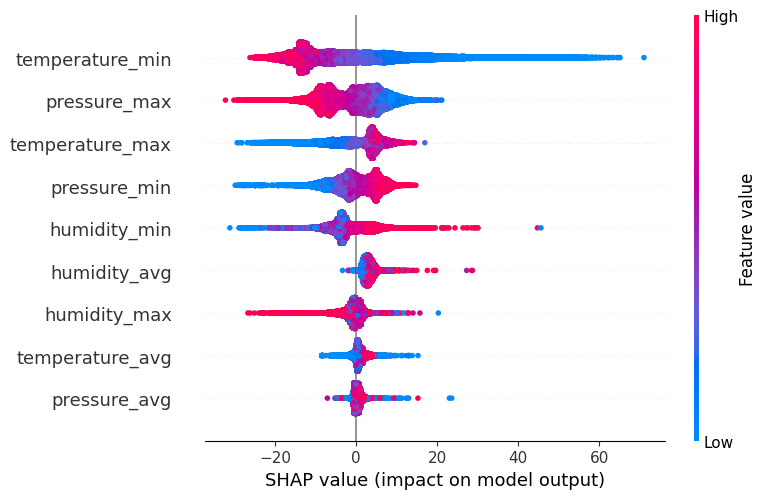

In [15]:
dtree_pm25 = xgb.XGBRegressor(min_samples_split=20)
dtree_pm25.fit(X_train_pm25, y_train_pm25)
ex = shap.Explainer(dtree_pm25)
shap_values_pm25 = ex.shap_values(X_test_pm25)
shap.summary_plot(shap_values_pm25, X_test_pm25)

In [16]:

y_pred_pm10 = dtree_pm10.predict(X_test)
y_pred_pm25 = dtree_pm25.predict(X_test_pm25)

In [17]:
from matplotlib.dates import DateFormatter

In [18]:
dates_test = df_actually_ready.index[len(X_train):]
dates_test

DatetimeIndex(['2023-03-29', '2023-03-29', '2023-03-29', '2023-03-29',
               '2023-03-29', '2023-03-29', '2023-03-29', '2023-03-29',
               '2023-03-29', '2023-03-29',
               ...
               '2023-06-22', '2023-06-22', '2023-06-22', '2023-06-22',
               '2023-06-22', '2023-06-22', '2023-06-22', '2023-06-22',
               '2023-06-22', '2023-06-22'],
              dtype='datetime64[ns]', name='date', length=142117, freq=None)

In [19]:
downsample_factor = 2000
dates_test_downsampled = dates_test[::downsample_factor]
y_test_pm10_downsampled = y_test_pm10[::downsample_factor]
y_pred_pm10_downsampled = y_pred_pm10[::downsample_factor]
y_test_pm25_downsampled = y_test_pm25[::downsample_factor]
y_pred_pm25_downsampled = y_pred_pm10[::downsample_factor]


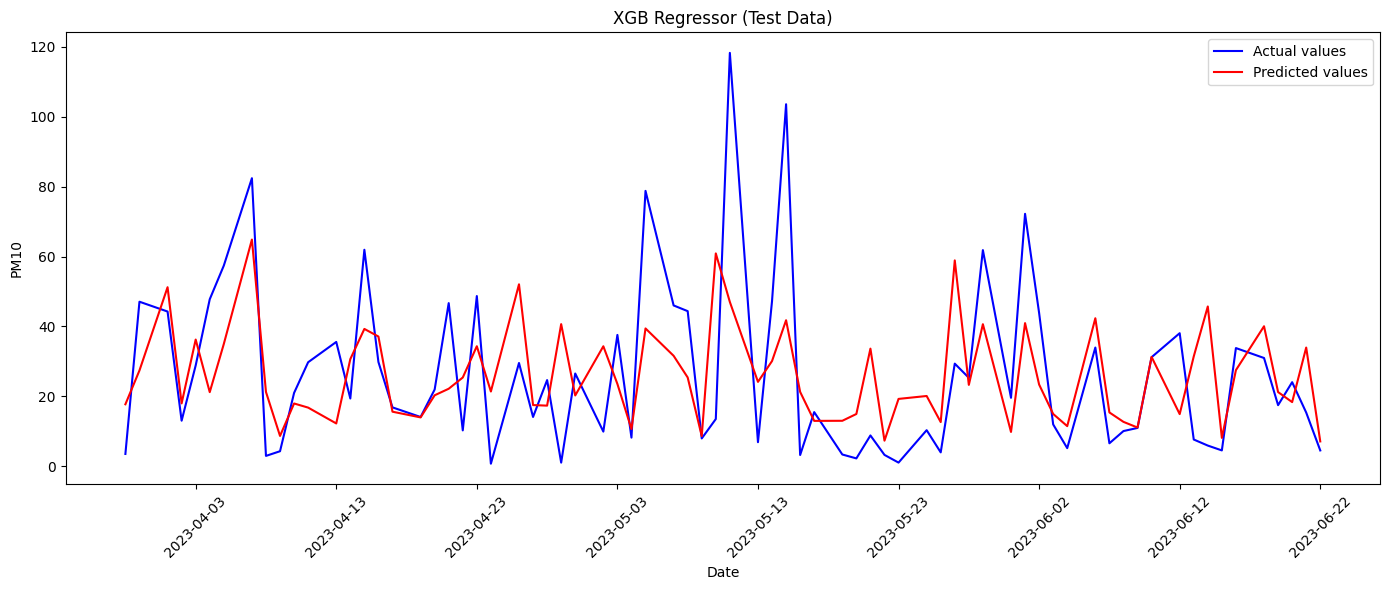

In [21]:
# Plot the downsampled true values and predictions for the test data only
plt.figure(figsize=(14, 6))
plt.plot(dates_test_downsampled, y_test_pm10_downsampled, color='blue', label='Actual values')
plt.plot(dates_test_downsampled, y_pred_pm10_downsampled, color='red', label='Predicted values')

# Format the x-axis to make it more readable
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.title('XGB Regressor (Test Data)')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


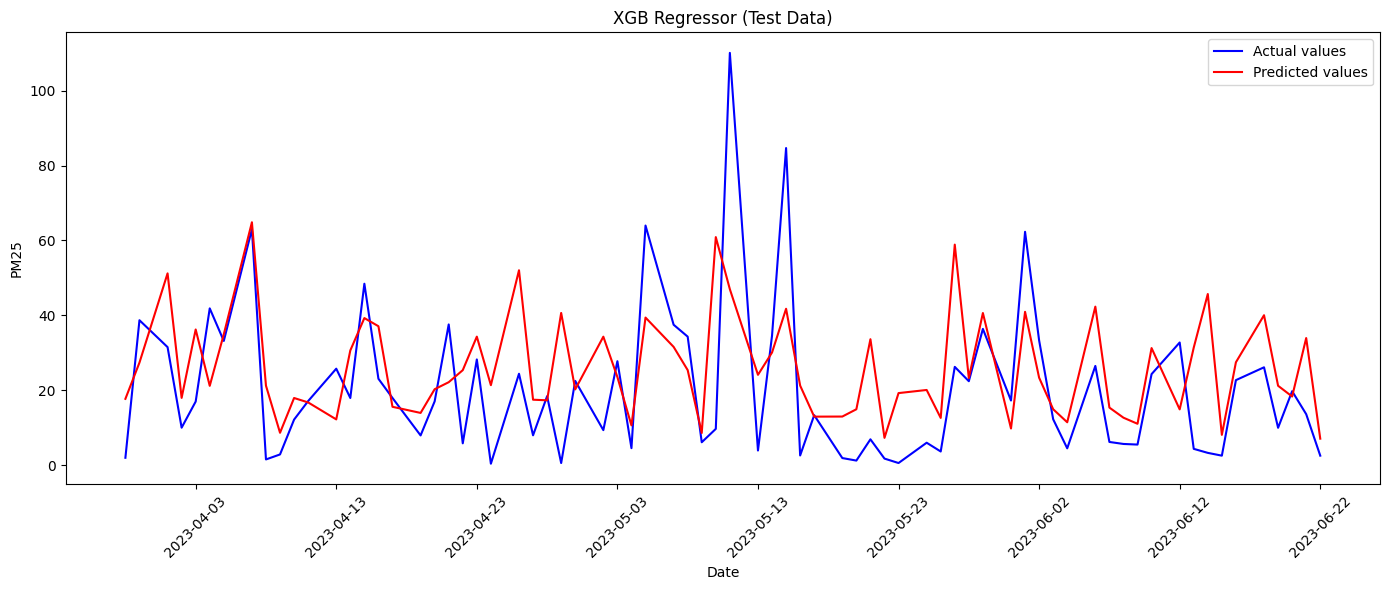

In [22]:
# Plot the downsampled true values and predictions for the test data only
plt.figure(figsize=(14, 6))
plt.plot(dates_test_downsampled, y_test_pm25_downsampled, color='blue', label='Actual values')
plt.plot(dates_test_downsampled, y_pred_pm25_downsampled, color='red', label='Predicted values')

# Format the x-axis to make it more readable
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.title('XGB Regressor (Test Data)')
plt.xlabel('Date')
plt.ylabel('PM25')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


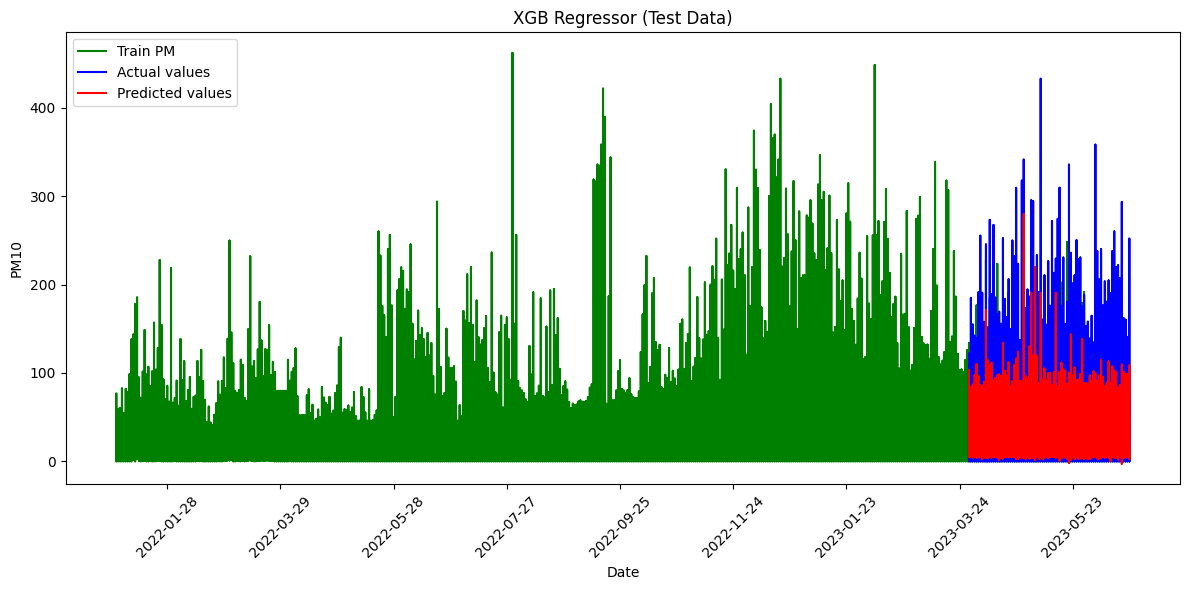

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df_actually_ready.index, df_ready["pm10_avg"], color='green', label = 'Train PM')
plt.plot(dates_test, y_test_pm10, color='blue', label='Actual values')
plt.plot(dates_test, y_pred_pm10, color='red', label='Predicted values')


plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.title('XGB Regressor (Test Data)')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


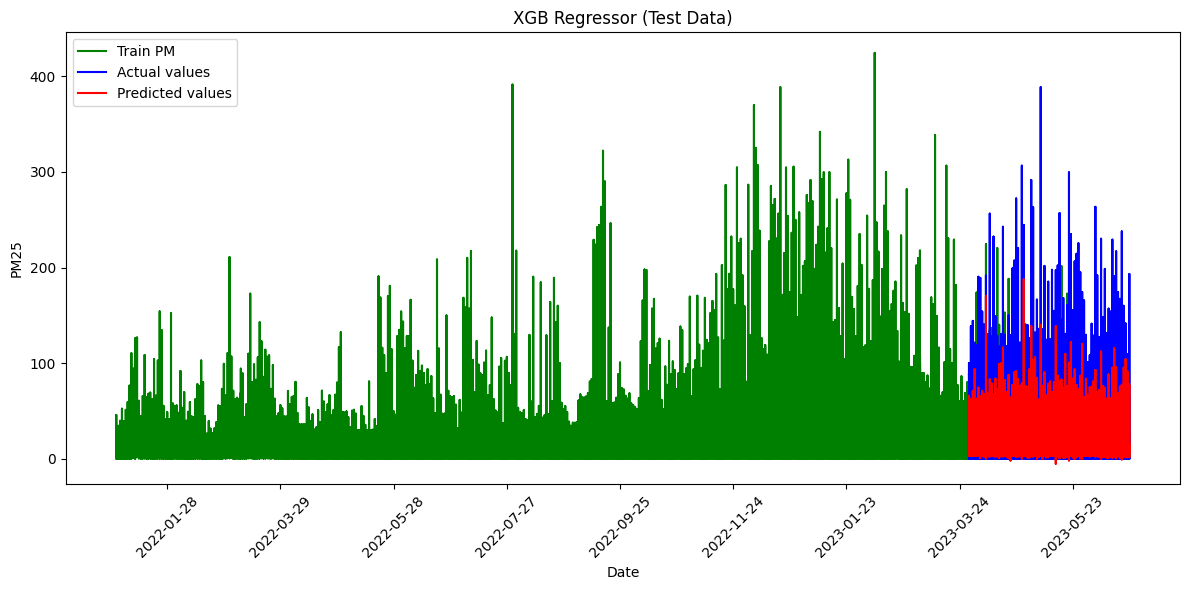

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df_actually_ready.index, df2["pm25_avg"], color='green', label = 'Train PM')
plt.plot(dates_test, y_test_pm25, color='blue', label='Actual values')
plt.plot(dates_test, y_pred_pm25, color='red', label='Predicted values')

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.title('XGB Regressor (Test Data)')
plt.xlabel('Date')
plt.ylabel('PM25')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()